<a href="https://colab.research.google.com/github/carloscesar182/ai_advanced_course/blob/main/Notebooks/RNA/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping # recurso que busca minimizar overfitting parando o treinamento se alguma condição ocorrer
from sklearn.preprocessing import MinMaxScaler # pra normalizar os dados

In [ ]:
# importar dados de treino
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

# ver como é o arquivo
dataset_train

In [ ]:
# ver o formato do arquivo
dataset_train.shape

In [ ]:
# separar os dados de abertura
training_set = dataset_train.iloc[:, 1:2].values
training_set

In [ ]:
# normalizar os dados
sc = MinMaxScaler(feature_range = (0, 1)) # feature_range define o limiar pra ele escalonar os dados (entre 0 e 1)
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

In [ ]:
# transformar os dados na estrutura tabular com 60 intervalos
X_train = [] # 60 intervalos
y_train = [] # classe

# laço pra criação do objeto
for i in range(60, 1258): # 1258 é o num de linhas da base
  X_train.append(training_set_scaled[i-60:i, 0]) # adiciona a lista que criamos os 60 dias pra traz
  y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# verificações
print('tabela', X_train)
print('formato', X_train.shape)

In [ ]:
# ajustar os dados pro formato que o keras exige (3 dimensões)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

In [ ]:
# construir as camadas da rna
modelo = Sequential()

# 4 camadas dropout
# input_shape pega o formato do X_train.shape, 1 que é a outra camada
modelo.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
modelo.add(Dropout(0.2)) # pra reduzir risco de overfitting eliminando alguns neuronios

# segunda camada
modelo.add(LSTM(units = 50, return_sequences = True))
modelo.add(Dropout(0.2))

# terceira camada
modelo.add(LSTM(units = 50, return_sequences = True))
modelo.add(Dropout(0.2))

# quarta camada
modelo.add(LSTM(units = 50))
modelo.add(Dropout(0.2))

# por fim a camada densa
modelo.add(Dense(units = 1)) # apenas 1 neuronio pq é um problema de regressão

In [ ]:
# compilar a rede
modelo.compile(optimizer = 'adam', loss = 'mean_squared_error')

# o modelo treina e valida a performance com dados de treino, mas posso definir um conjunto de dados pra validação
# se tivesse esse conjunto de validação, o monitor receberia 'val_loss'
# mode = min indica que queremos monitorar o valor mínimo
# verbose = 1 pra ver a saída
# patience = 30 indica o numero de epochs sem evolução de loss pra ele parar
es = EarlyStopping(monitor='loss', mode=min, verbose=1, patience=30)

# fazer o fit usando early stopping
modelo.fit(X_train, y_train, epochs = 500, batch_size = 32, callbacks=[es])

In [ ]:
# obter os dados de teste
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [ ]:
# obter os dados previstos
# concatenar os dados originais antes de transformar. Coluna Open no axis 0 que é a concatenção a partir das linhas
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

In [ ]:
# pegar 60 dias anteriores ao primeiro dia de janeiro de 2017 até o último dado que temos
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

# deixar tudo em uma linha e uma coluna
inputs = inputs.reshape(-1,1)

# normalizar os inputs com o objeto que criamos pra transformação
inputs = sc.transform(inputs)

# mudar o tamanho dos dados de 1258 pra 80 pq o testeset tem apenas 20 dias
X_test = []
for i in range(60, 80):
  X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

# fazer o reshape pra 3 dimensões pra deixar no mesmo formato que usamos pra treinar
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# fazer a previsão
predicted_stock_price = modelo.predict(X_test)

# colocar a previsão de volta na escala original usando o inverse_transform que o inverso do transform do StandardScaler
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

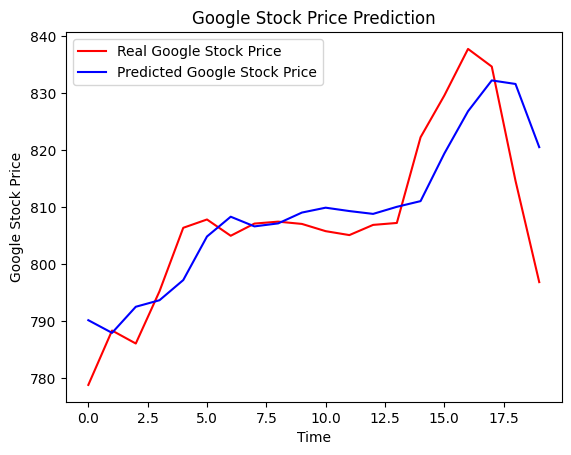

In [ ]:
# comparar a previsão com o que, de fato, aconteceu
# relembrando: fizemos a previsão de 20 dias após 2016, ou seja, os primeiros 20 dias de 2017
# agora vamos comparar com o real que aconteceu em 2017 na variavel dataset_test
# vamos então gerar um grafico de linhas. Uma linha com o que realmente aconteceu e outra com a previsão do modelo
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()